## Dataset: Kaggle NLP with Disaster Tweets
Predict which Tweets are about real disasters and which ones are not
- https://www.kaggle.com/c/nlp-getting-started/overview

Deep Learning Sequential Neural Network model with TensorFlow and Keras API

In [ ]:
!pip install tokenization
!pip install tweet-preprocessor

In [ ]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import tokenization
from sklearn import preprocessing
import preprocessor as p
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.metrics import BinaryAccuracy
import math

%matplotlib inline

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Load dataset
train_set = pd.read_csv('data/train.csv')
test_set = pd.read_csv('data/test.csv')
sample_submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
print(train_set.head(), '\n', 'Train set shape: ', train_set.shape)

   id keyword  ...                                               text target
0   1     NaN  ...  Our Deeds are the Reason of this #earthquake M...      1
1   4     NaN  ...             Forest fire near La Ronge Sask. Canada      1
2   5     NaN  ...  All residents asked to 'shelter in place' are ...      1
3   6     NaN  ...  13,000 people receive #wildfires evacuation or...      1
4   7     NaN  ...  Just got sent this photo from Ruby #Alaska as ...      1

[5 rows x 5 columns] 
 Train set shape:  (7613, 5)


In [ ]:
train_set.drop_duplicates('text', keep = 'last', inplace = True)
print('Train set shape without duplicates: ', train_set.shape)

train_set.reset_index(inplace = True)

Train set shape without duplicates:  (7503, 5)


In [ ]:
print(test_set.head(), '\n', 'test set shape: ', test_set.shape)

   id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills 28 in China and Taiwan 
 test set shape:  (3263, 4)


In [ ]:
# Encoding labels
label = preprocessing.LabelEncoder()
train_y = label.fit_transform(train_set['target'])

print('Train set shape: ', train_y.shape, train_y.dtype)
print('Disaster tweets on training set: ', np.count_nonzero(train_y == 1))
print('Non-disaster tweets on training set: ', np.count_nonzero(train_y == 0))

Train set shape:  (7503,) int64
Disaster tweets on training set:  3196
Non-disaster tweets on training set:  4307


### Tweets Preprocessing

In [ ]:
# Analyzing unique keywords on original datasets
train_set['keyword'].value_counts()

fatalities               45
armageddon               42
deluge                   42
harm                     41
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 221, dtype: int64

In [ ]:
test_set['keyword'].value_counts()

deluged                  23
rubble                   22
demolished               22
snowstorm                21
sirens                   21
                         ..
radiation%20emergency     5
forest%20fire             5
threat                    5
inundation                4
epicentre                 1
Name: keyword, Length: 221, dtype: int64

In [ ]:
unique_keys = set(np.concatenate((test_set['keyword'].unique(), train_set['keyword'].unique())))
len(unique_keys) -1 # Removing nan
# Distribution of unique keys are the same within training and test datasets

221

In [ ]:
# Capturing new keywords with Hashtag Extraction using Regex
def hashtag_extract(tweet):
  """
  Extract hashtag from text strings within individual tweets.
  
  Argument: tweet -- String.
  Returns: hashtag -- List of lowercase strings. Hashtags contained on tweet.
  """
  hashtag = re.findall(r"#(\w+)", tweet)
  hashtag = list(map(str.lower, hashtag))
  return hashtag

train_set['hashtags'] = train_set['text'].apply(hashtag_extract)
train_set.head()

,index,id,keyword,location,text,target,hashtags
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,[earthquake]
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,[]
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,[]
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,[wildfires]
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[alaska, wildfires]"


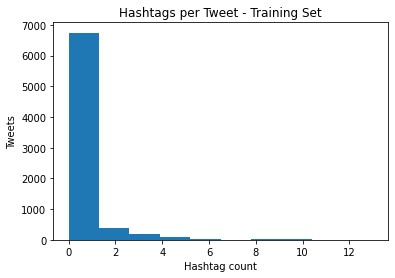

In [ ]:
# Analyzing hashtag counts per tweet
lengths = []
for hashtags in train_set['hashtags']:
  lengths.append(len(hashtags))

plt.hist(lengths)
plt.title('Hashtags per Tweet - Training Set')
plt.xlabel('Hashtag count')
plt.ylabel('Tweets');

In [ ]:
# Capturing Hashtags on test dataset
test_set['hashtags'] = test_set['text'].apply(hashtag_extract)
test_set.head()

,id,keyword,location,text,hashtags
0,0,NaN,NaN,Just happened a terrible car crash,[]
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",[earthquake]
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",[]
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,"[spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,[]


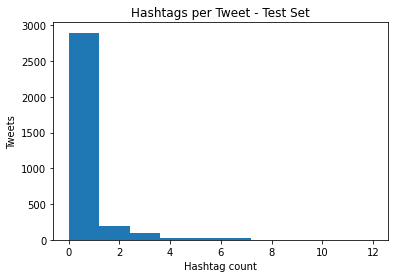

In [ ]:
lengths = []
for hashtags in test_set['hashtags']:
  lengths.append(len(hashtags))

plt.hist(lengths)
plt.title('Hashtags per Tweet - Test Set')
plt.xlabel('Hashtag count')
plt.ylabel('Tweets');

# Distribution of hashtag counts is compatible within test and training datasets

In [ ]:
# Text cleaning - Removing URLs, mentions, etc using tweet-preprocessor package
def tweet_clean(tweet):
  """
  Clean tweet with tweet-preprocessor p.clean() removing unwanted characters,
  user mentions, punctuations and setting to lower case text.

  Argument: tweet -- Ttext string.
  Returns: cleaned_tweet -- Cleaned tweet text string.
  """
  # Remove user mentions, symbols and unwanted characters
  tweet = p.clean(tweet)

  # Remove digits and setting lower case text
  tweet = tweet.replace('\d+', '').lower()

  # Remove punctuations
  cleaned_tweet = re.sub(r'[^\w\s]', '', tweet)

  return cleaned_tweet

train_set['text'] = train_set['text'].apply(tweet_clean)
test_set['text'] = test_set['text'].apply(tweet_clean)

print('First 5 cleaned train_set tweets :\n', train_set['text'].head(), '\n')
print('First 5 cleaned test_set tweets :\n', test_set['text'].head())

First 5 cleaned train_set tweets :
 0    our deeds are the reason of this may allah for...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3       people receive evacuation orders in california
4    just got sent this photo from ruby as smoke fr...
Name: text, dtype: object 

First 5 cleaned test_set tweets :
 0                   just happened a terrible car crash
1    heard about is different cities stay safe ever...
2    there is a forest fire at spot pond geese are ...
3                                  apocalypse lighting
4           typhoon soudelor kills in china and taiwan
Name: text, dtype: object


In [ ]:
# Stemming, Lemmatization and Tokenization using nltk package
def tweet_preprocess(tweet):
  """
  Process tweets with stemming, lemmatization, tokenization, and removing stopwords.
  Stopwords dictionary = English

  Arguments: tweet -- String.
  Returns: processed_tweed -- List of strings with stemmed lemmatized tokenized
  words contained in tweet, without stopwords.
  """
  stemmer = nltk.SnowballStemmer('english')
  lemmatizer = nltk.stem.WordNetLemmatizer()
  tokenizer = TweetTokenizer()
  stop_words = set(stopwords.words('english')) # Create stopwords set

  # Stemming (having -> have)
  tweet = stemmer.stem(tweet)

  # Lemmatization ('dogs' -> 'dog') and 
  # Tokenization ('good muffins cost $10' -> ['good', 'muffins', 'cost', '$', '10'])
  tweet = [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(tweet)]

  # Removing stop words (a, an, our, etc.)
  processed_tweet = []
  for word in tweet:
    if word not in stop_words:
      processed_tweet.append(word)

  return processed_tweet

train_set['text'] = train_set['text'].apply(tweet_preprocess)
test_set['text'] = test_set['text'].apply(tweet_preprocess)

print('First 5 processed train_set tweets :\n', train_set['text'].head(), '\n')
print('First 5 processed test_set tweets :\n', test_set['text'].head())

First 5 processed train_set tweets :
 0           [deed, reason, may, allah, forgive, u, al]
1        [forest, fire, near, la, ronge, sask, canada]
2    [resident, asked, shelter, place, notified, of...
3     [people, receive, evacuation, order, california]
4       [got, sent, photo, ruby, smoke, pours, school]
Name: text, dtype: object 

First 5 processed test_set tweets :
 0                     [happened, terrible, car, crash]
1        [heard, different, city, stay, safe, everyon]
2    [forest, fire, spot, pond, goose, fleeing, acr...
3                                  [apocalypse, light]
4             [typhoon, soudelor, kill, china, taiwan]
Name: text, dtype: object


In [ ]:
# Adding hashtag to tweets
for i, hashtag in enumerate(train_set['hashtags']):
  for hashtag in train_set.loc[i, 'hashtags']:
    train_set.loc[i, 'text'].append(hashtag)

train_set

,index,id,keyword,location,text,target,hashtags
0,0,1,NaN,NaN,"[deed, reason, may, allah, forgive, u, al, ear...",1,[earthquake]
1,1,4,NaN,NaN,"[forest, fire, near, la, ronge, sask, canada]",1,[]
2,2,5,NaN,NaN,"[resident, asked, shelter, place, notified, of...",1,[]
3,3,6,NaN,NaN,"[people, receive, evacuation, order, californi...",1,[wildfires]
4,4,7,NaN,NaN,"[got, sent, photo, ruby, smoke, pours, school,...",1,"[alaska, wildfires]"
...,...,...,...,...,...,...,...
7498,7608,10869,NaN,NaN,"[two, giant, crane, holding, bridge, collapse,...",1,[]
7499,7609,10870,NaN,NaN,"[control, wild, fire, california, even, northe...",1,[]
7500,7610,10871,NaN,NaN,"[m194, 0104, utc, 5km, volcano, hawaii]",1,[]
7501,7611,10872,NaN,NaN,"[police, investigating, ebike, collided, car, ...",1,[]


In [ ]:
# Tokenizing text data into matrix form using Keras text preprocessing
def sequentialize(tweets, max_words = 5000, words_per_element = 50, enforce_words_per_element = False):
  """
  Sequentialize tweets into an (m, x) matrix, where:
  m = number of tweet samples
  x = dimension of individual tweet object, after tokenized

  Arguments:
  tweets -- preprocessed tweets. Each individual element should be contained into a list.
            Use tweet_preprocess() function before sequentialize()
  max_words -- Int. Hyperparameter where only the most common (max_words - 1) will be kept,
            based on word frequency
  words_per_element -- Int. Default = 50. Maximum dimension of individual tweet vectors,
            padded with zeros. Also seen as number of features per training/testing element.
            Automatically set to the maximum number needed per individual tweet, after a
            first sequentialize iteration.
  enforce_words_per_element -- Boolean. Default = False. When 'True', enforces the inputed
            words_per_element value into the final tweet vector.

  Returns:
  sequences_matrix -- Numpy array of shape (m, x).
  """
  # max_words = 5000
  # Hyperparameter: Only the most common (max_words - 1) will be kept, based on word frequency

  global max_len
  max_len = words_per_element
  # max_len = 5
  # Number of words to pad and fit into feature X matrix

  tok = Tokenizer(num_words = max_words)
  X = tweets

  tok.fit_on_texts(X) # Updates internal vocabulary based on list of texts
  sequences = tok.texts_to_sequences(X) # Tokenize word sequences
  sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)

  # Checking token counts per tweet
  word_counts = []
  for i in range(0, sequences_matrix.shape[0]):
    word_counts.append(np.count_nonzero(sequences_matrix[i, :]))

  if (max(word_counts) < max_len) and not enforce_words_per_element:
    max_len = max(word_counts)
    sequences_matrix = sequence.pad_sequences(sequences, maxlen = max_len)
    print('max_words_per_element value updated:', max_len)

  global highest_word_token
  highest_word_token = max(list(max(i) for i in sequences_matrix[:, ]))

  print(f'Highest word token: {highest_word_token}')

  return sequences_matrix

sequences_matrix = sequentialize(train_set['text'], max_words = 10000)

print(sequences_matrix.shape, sequences_matrix.dtype)
print(sequences_matrix[0, :])
print(sequences_matrix[0, :].shape)

max_words_per_element value updated: 23
Highest word token: 9999
(7503, 23) int32
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 5897  417   69 1665 3978    9  622  182]
(23,)


Maximum token count per tweet: 23 



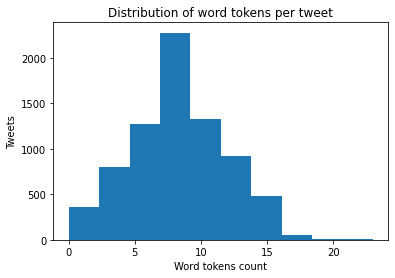

In [ ]:
# Analyzing word counts after tokenizing into matrices
word_counts = []
for i in range(0, sequences_matrix.shape[0]):
  word_counts.append(np.count_nonzero(sequences_matrix[i, :]))

print(f'Maximum token count per tweet:', max(word_counts), '\n')

plt.hist(word_counts)
plt.title('Distribution of word tokens per tweet')
plt.xlabel('Word tokens count')
plt.ylabel('Tweets');

In [ ]:
# Defining train_X and train_Y vectors
train_X = (sequences_matrix/highest_word_token) # Scaled sequences_matrix with shape (m, x_i)
train_Y = train_set['target'].values.reshape((train_set['target'].shape[0], -1)) # Y vector flattened from train_set['target']

print('First element (example) of training set: ', train_X[0, :], '\n')
print('Training set train_X shape: ', train_X.shape, '\n-------------------\n')
print('Y_1: ', train_Y[0, :], '\n')
print('Training set train_Y shape: ', train_Y.shape)

First element (example) of training set:  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.58975898 0.04170417 0.00690069
 0.16651665 0.39783978 0.00090009 0.06220622 0.01820182] 

Training set train_X shape:  (7503, 23) 
-------------------

Y_1:  [1] 

Training set train_Y shape:  (7503, 1)


### Neural Network
Sequential Neural Network implementation with TensorFlow and Keras API.

In [ ]:
from tensorflow import keras

In [ ]:
model = keras.Sequential([keras.layers.Dense(16, activation = "ReLU"),
                          keras.layers.Dense(16, activation = "ReLU"),
                          keras.layers.Dense(1, activation = "sigmoid")])

model.compile(optimizer = keras.optimizers.RMSprop(learning_rate= 1e-3),
              loss = keras.losses.BinaryCrossentropy(),
              metrics = [keras.metrics.BinaryAccuracy()])

In [ ]:
# Shuffling inputs and targets using a random indice permutation
# This avoid having only one class in the validation data
indices_permutation = np.random.permutation(len(train_X))
shuffled_inputs = train_X[indices_permutation]
shuffled_targets = train_Y[indices_permutation]

# Validation set with 30% of training inputs
num_validation_samples = int(0.25 * len(train_X))
val_inputs = shuffled_inputs[:num_validation_samples]
val_targets = shuffled_targets[:num_validation_samples]
training_inputs = shuffled_inputs[num_validation_samples:]
training_targets = shuffled_targets[num_validation_samples:]

In [ ]:
print(f'Training set: {training_inputs.shape}, with labels: {training_targets.shape}\n')
print(f'Validation set: {val_inputs.shape}, with labels: {val_targets.shape}')

Training set: (5628, 23), with labels: (5628, 1)

Validation set: (1875, 23), with labels: (1875, 1)


### Running Model

In [ ]:
# Training
history = model.fit(training_inputs,
                    training_targets,
                    epochs = 250,
                    batch_size = 16,
                    validation_data = (val_inputs, val_targets))

Epoch 1/250
352/352 [==============================] - 2s 5ms/step - loss: 0.6340 - binary_accuracy: 0.6434 - val_loss: 0.6813 - val_binary_accuracy: 0.5867
Epoch 2/250
352/352 [==============================] - 2s 5ms/step - loss: 0.6336 - binary_accuracy: 0.6423 - val_loss: 0.6831 - val_binary_accuracy: 0.5904
Epoch 3/250
352/352 [==============================] - 2s 5ms/step - loss: 0.6323 - binary_accuracy: 0.6484 - val_loss: 0.6868 - val_binary_accuracy: 0.5957
Epoch 4/250
352/352 [==============================] - 2s 5ms/step - loss: 0.6327 - binary_accuracy: 0.6464 - val_loss: 0.6848 - val_binary_accuracy: 0.5883
Epoch 5/250
352/352 [==============================] - 2s 5ms/step - loss: 0.6321 - binary_accuracy: 0.6414 - val_loss: 0.6836 - val_binary_accuracy: 0.5829
Epoch 6/250
352/352 [==============================] - 2s 5ms/step - loss: 0.6317 - binary_accuracy: 0.6478 - val_loss: 0.6829 - val_binary_accuracy: 0.5920
Epoch 7/250
352/352 [==============================] - 2s 

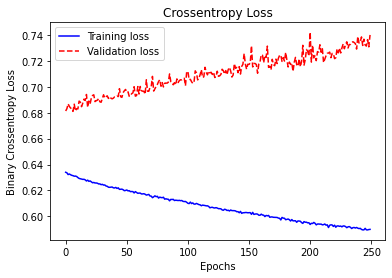

In [ ]:
plt.plot(history.history['loss'], 'b-', label = "Training loss")
plt.plot(history.history['val_loss'], 'r--', label = "Validation loss")
plt.xlabel('Epochs')
plt.ylabel('Binary Crossentropy Loss')
plt.title('Crossentropy Loss')
plt.legend();

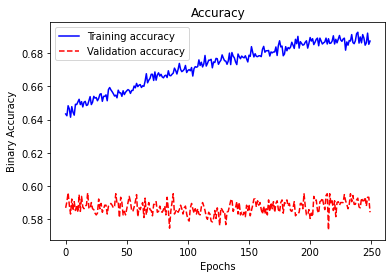

In [ ]:
plt.plot(history.history['binary_accuracy'], 'b-', label = "Training accuracy")
plt.plot(history.history['val_binary_accuracy'], 'r--', label = "Validation accuracy")
plt.xlabel('Epochs')
plt.ylabel('Binary Accuracy')
plt.title('Accuracy')
plt.legend();

In [ ]:
# Predictions
predictions = model(train_X)

In [ ]:
model.evaluate(train_X, train_Y, batch_size = 128)

59/59 [==============================] - 0s 2ms/step - loss: 0.3512 - binary_accuracy: 0.8381


[0.35116514563560486, 0.8380647897720337]

In [ ]:
test_set['hashtags']

0                              []
1                    [earthquake]
2                              []
3            [spokane, wildfires]
4                              []
                  ...            
3258                           []
3259                           []
3260                           []
3261                           []
3262    [cityofcalgary, yycstorm]
Name: hashtags, Length: 3263, dtype: object

### Fitting Test Set

In [ ]:
# Adding hashtag to tweets at test data
for i, hashtag in enumerate(test_set['hashtags']):
  for hashtag in test_set.loc[i, 'hashtags']:
    test_set.loc[i, 'text'].append(hashtag)

test_set

,id,keyword,location,text,hashtags
0,0,NaN,NaN,"[happened, terrible, car, crash]",[]
1,2,NaN,NaN,"[heard, different, city, stay, safe, everyon, ...",[earthquake]
2,3,NaN,NaN,"[forest, fire, spot, pond, goose, fleeing, acr...",[]
3,9,NaN,NaN,"[apocalypse, light, spokane, wildfires]","[spokane, wildfires]"
4,11,NaN,NaN,"[typhoon, soudelor, kill, china, taiwan]",[]
...,...,...,...,...,...
3258,10861,NaN,NaN,"[earthquake, safety, los, angeles, safety, fas...",[]
3259,10865,NaN,NaN,"[storm, ri, worse, last, hurricane, cityamp, 3...",[]
3260,10868,NaN,NaN,"[green, line, derailment, chicago]",[]
3261,10874,NaN,NaN,"[meg, issue, hazardous, weather, outlook, hwo]",[]


In [ ]:
# Sequentialize test dataset
test_sequences_matrix = sequentialize(test_set['text'], max_words = 10000,
                                      words_per_element = 23, enforce_words_per_element = True)

print(test_sequences_matrix.shape, test_sequences_matrix.dtype)
print(test_sequences_matrix[0, :])
print(test_sequences_matrix[0, :].shape)

Highest word token: 8742
(3263, 23) int32
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0 668 958  52  36]
(23,)


Maximum token count per tweet: 22 



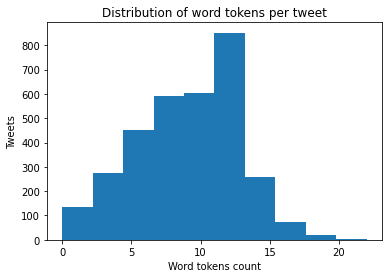

In [ ]:
# Analyzing word counts after tokenizing into matrices
word_counts = []
for i in range(0, test_sequences_matrix.shape[0]):
  word_counts.append(np.count_nonzero(test_sequences_matrix[i, :]))

print(f'Maximum token count per tweet:', max(word_counts), '\n')

plt.hist(word_counts)
plt.title('Distribution of word tokens per tweet')
plt.xlabel('Word tokens count')
plt.ylabel('Tweets');

In [ ]:
# Defining test_X vector
test_X = (test_sequences_matrix/highest_word_token) # Scaled test_sequences_matrix with shape (x_i, m)

print('First element on test set: ', test_X[:, 0], '\n')
print('Training set test_X shape: ', test_X.shape)

First element on test set:  [0. 0. 0. ... 0. 0. 0.] 

Training set test_X shape:  (3263, 23)


In [ ]:
# Fitting test data
test_predictions = model(test_X)

In [ ]:
test_predictions

<tf.Tensor: shape=(3263, 1), dtype=float32, numpy=
array([[ 0.40473047],
       [ 0.63498986],
       [ 0.3774104 ],
       ...,
       [ 0.26415262],
       [ 0.47545317],
       [-0.03571688]], dtype=float32)>

In [ ]:
predicted = []
for i in test_predictions.numpy():
  if i > 0.5:
    predicted.append(1)
  else:
    predicted.append(0)

In [ ]:
# Creating submission dataset
submission = pd.read_csv('data/sample_submission.csv')
submission['target'] = predicted
submission

,id,target
0,0,0
1,2,1
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,1
3259,10865,1
3260,10868,0
3261,10874,0


In [ ]:
submission.to_csv('data/submission.csv', index = False, header = True)